In [14]:
!pip install duckdb==0.2.7

In [15]:
!pip install awswrangler

In [16]:
!pip uninstall -y pandas

Found existing installation: pandas 1.4.4
Uninstalling pandas-1.4.4:
  Successfully uninstalled pandas-1.4.4


In [17]:
!pip install pandas==1.4.4

  Using cached pandas-1.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached pandas-1.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.0.5 requires pandas>=2, but you have pandas 1.4.4 which is incompatible.


In [18]:
!pip show pandas

Name: pandas
Version: 1.4.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages
Requires: numpy, python-dateutil, pytz
Required-by: autovizwidget, awswrangler, bokeh, dask-expr, hdijupyterutils, sagemaker, seaborn, shap, sparkmagic, statsmodels


** ** 
** **

## **INGRESA NOMBRE DE JSON DE PARAMETROS** 

Respetar el formato para las carpetas **ejecuciones/periodo/cartera/nombres_json.json**\
Todo con minusculas

In [19]:
##############################################################################################################
#INGRESAR PARAMETROS#

periodo = "202404"
cartera = "consumo"
version = "FWL0596_replica"
    
##############################################################################################################
import re
year = "2024"
import json

CARPETA = f"ejecuciones/{periodo}/{cartera}/{version}"
PARAMS_NAME = f"params_{cartera}_{periodo}_v{version}.json"

PARAMS_PATH = f'{CARPETA}/{PARAMS_NAME}'

with open(PARAMS_PATH, 'r') as file:
    params_inputs = json.load(file)
    
print("Outputs:", CARPETA)
print("Nombre del json params:", PARAMS_NAME)

Outputs: ejecuciones/202404/consumo/FWL0596_replica
Nombre del json params: params_consumo_202404_vFWL0596_replica.json


** ** 
** **

In [20]:
# import re
year = "2024"
import json
from datetime import datetime
from dateutil.relativedelta import *
from libs.SageMakerFunx import *
from libs.SageMakerTimeFunx import *
from datetime import datetime
from IPython.core.magic import register_line_magic

@register_line_magic
def print_execution_time(line):
    now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f"Execution Time: {now}")
    
PARAMS_PATH = f'{CARPETA}/{PARAMS_NAME}'

with open(PARAMS_PATH, 'r') as file:
    params_inputs = json.load(file)

registro = params_inputs["params_variables"]['registro']   # Nombre de la carpeta
registro_ejecucion = params_inputs["params_variables"]['registro_ejecucion'] # Usuario que ejecuta el notebook
cartera = params_inputs["params_variables"]['cartera']
periodo = params_inputs["params_variables"]['periodo']
version = params_inputs["params_variables"]['version']
fwl_table_v = params_inputs["params_variables"]['fwl_table_v']

portfolio_filter = Portfolio_fwl_filter(cartera.lower())
cartera, fwl_portfolio_name = portfolio_filter.get_actual_portfolio_name()

json_file = f"JSON_{cartera.upper()}_{periodo}_v{version}.json"
notebook_name = f"HE_{cartera.upper()}_{periodo}_v{version}.ipynb"

# parametros del notebook
nb_params = {'registro': registro.lower(),
             'registro_ejec': registro_ejecucion.lower(),
             'cartera': cartera.lower(),
             'periodo': periodo.lower(),
             'version': version.lower(),
             'fwl_table_version':fwl_table_v,
             'sufijo': params_inputs["sufijos_cartera"][cartera],
             'grupo_archivos': params_inputs["file_group"][cartera].lower(),
             'filtro_cartera_fwl': fwl_portfolio_name,
             'json_file': json_file}

vector_tables = list(value[1] for value in params_inputs["params_variables"]["tbl_names_per_portfolio"][nb_params['grupo_archivos']].values())
# imprimir parametros
print(f"PARÁMETROS DEL NOTEBOOK PARA {cartera.upper()}_{periodo}_v{version}\n")
for nb_param, nb_key in nb_params.items():
    print(f"{nb_param}: {nb_key}")
print("--------------------------------------------------------------------") 
print(" ")   
# 1: version nueva y 0 version actual (todo 1)
print(f"Status de tablas disponibles {nb_params['cartera'].upper()}\n")

tbl_names_per_portfolio = reemplazar_params(params_inputs["params_variables"]["tbl_names_per_portfolio"][nb_params['grupo_archivos']], nb_params)

if fwl_table_v != "0":
    tbl_names_per_portfolio['tbl_stress_pd'][1] = 1

# total_tbl_names = tbl_names_per_portfolio[nb_params['grupo_archivos']]
# new_tables = Read_preprocessing(vector_params, total_tbl_names, tablas_dict.copy(), nb_params).get_new_tables()
    
max_width = max(len(key) for key in tbl_names_per_portfolio.keys())
max_value_width = max(len(value[0]) for value in tbl_names_per_portfolio.values())

for key, value in tbl_names_per_portfolio.items():
    # Ajustar el nombre de la tabla al ancho máximo con espacios
    key_aligned = key.ljust(max_width)
    arrow_padding = int(max_value_width/0.8) - len(value[0])
    arrow_string = '-' * arrow_padding

    # Crear la salida final con flechas
    print(f"{key_aligned}: {value[0]} {arrow_string}> status: {value[1]}")
print("--------------------------------------------------------------------") 
print(" ")

number_of_thresholds = [number for number, list_portfolio in params_inputs["threshold_per_portfolio"].items() 
                                if nb_params['cartera'] in list_portfolio][0]
print("UMBRALES")
print(f"Cartera: {nb_params['cartera'].upper()}")
print(f"Numero de umbrales usados: {number_of_thresholds}\n")
thresholds = list(params_inputs["params_variables"]["umbrales"][str(number_of_thresholds)].values())
for key, value in params_inputs["params_variables"]["umbrales"][str(number_of_thresholds)].items():
    print(f'{key}: ', value)
print("--------------------------------------------------------------------") 
print(" ")

n_peso_b = params_inputs["params_variables"]["pesos"]["n_peso_b"]
n_peso_o = params_inputs["params_variables"]["pesos"]["n_peso_o"]
n_peso_p = params_inputs["params_variables"]["pesos"]["n_peso_p"]

pesos = params_inputs["params_variables"]["pesos"]

print("PESOS")
print(f"Cartera: {nb_params['cartera'].upper()}\n")
for key, value in params_inputs["params_variables"]["pesos"].items():
    print(f'{key}: ', value)
print("--------------------------------------------------------------------") 
print(" ")
%print_execution_time

PARÁMETROS DEL NOTEBOOK PARA CONSUMO_202404_vFWL0596_replica

registro: s41800
registro_ejec: s41800
cartera: consumo
periodo: 202404
version: fwl0596_replica
fwl_table_version: 0596
sufijo: con
grupo_archivos: con
filtro_cartera_fwl: Consumo
json_file: JSON_CONSUMO_202404_vFWL0596_replica.json
--------------------------------------------------------------------
 
Status de tablas disponibles CONSUMO

tbl_newscore        : hoa_67_new_score_v1_con_202404 ----------------> status: 0
tbl_new_primer_score: hoa_66_tr_score_inicial_v1_con_202404 ---------> status: 0
tbl_bucket_pd       : hoa_tabla_pd_bucket_v2_202404 -----------------> status: 1
tbl_lgd             : hoa_tabla_lgd_v4 ------------------------------> status: 0
tbl_ccf             : hoa_tabla_ccf_v2 ------------------------------> status: 0
tbl_bucket_limites  : hoa_limites_buckets_v1_202404 -----------------> status: 1
tbl_stress_pd       : hoa_fwl_ibk_v0596_202404 ----------------------> status: 1
----------------------------

In [21]:
import json

bucket_name = params_inputs['rutas']['bucket']
file_key = f"{params_inputs['rutas']['carpet_prefix']}/Inputs_json/{nb_params['periodo']}/{nb_params['json_file']}"

log_ejec_global = []
log_ejec_global_json = [] 
log_ejec_unico = []
n_paso_ejecucion = 0

s3_json = S3()
# Carga JSON
file_json = f"s3://{bucket_name}/{file_key}"
print("file_json: ", file_json)

reponse_json = s3_json.obtain_data(log_ejec_global_json, bucket_name, file_key)
json_content = reponse_json["Body"].read().decode("utf-8") # **Ejecucion Parcial**

data = json.loads(json_content)

tablas_dict = {}
general_params = {}
escenarios = []

s3 = S3()
database_field = data["confPython"]
database_config = {
    "host": database_field["host"],
    "region": database_field["region"],
    "folderS3": database_field["folderS3"],
    "folderS3Destino": database_field["folderS3Destino"],
    "bd": database_field["bd"],
    "tablaAvance": database_field["tablaAvance"]
}
log_ejec_global.append("Inicializacion BBDD Athena")
pro_data = Process_data(database_config["bd"], database_config["folderS3"], database_config["folderS3Destino"], database_config["region"]["id_region"])

# Datos de escenarios
escenario_index = 1
escenarios_field = data["escenarios"]
for escenario in escenarios_field:
    formatted_escenario_dict = {
        "t_nombre_escenario": escenario["nombre_escenario"],
        "t_escenario": escenario["nombre_escenario_motor"],
        "n_cod_escenario": escenario_index,
        "n_peso_escenario": escenario["n_peso"],
        "n_paso_ejecucion": escenario["n_paso_ejecucion"],
        "n_cod_ejecucion": escenario["n_cod_ejecucion"],
        "n_cod_escenario_version": escenario["n_cod_escenario_version"]
    }
    var_name = "n_peso_" + escenario["nombre_escenario"][0].lower()
    general_params[var_name] = escenario["n_peso"]
    escenarios.append(formatted_escenario_dict)
    escenario_index += 1

# Variables adicionales
agrupacion_adicionales = data["vars_agrupacion_adicionales"]
staging_adicionales = data["vars_staging_adicionales"]
tabla_avance = ''
n_region = ''

general_params["agrupacion_adicionales"] = agrupacion_adicionales
general_params["staging_adicionales"] = staging_adicionales

for key in data:
    if key not in ["bloques", "escenarios", "confTeradata", "vars_agrupacion_adicionales", "adicionales"]:
        lower_key = key.lower()
        general_params[lower_key] = data[key]

# Poblado de bloques a partir de las Tablas de la BD
bloques = data["bloques"]
tables_execution_start = time.time()
for bloque in bloques:
    if bloque["nombre_variable_motor"] != "Tbl_adicionales":
        keep_campos = []
        nombre_campos = []
        tipo_campos = {}

        for campo in bloque["campos"]:
            nombre_campo = '' if campo["nombre_campo"] is None else campo["nombre_campo"]
            nombre_variable = '' if campo["nombre_variable_motor"] is None else campo["nombre_variable_motor"].lower()
            nombre_campo_format = nombre_campo
            tipo = 'str'

            if (campo["tipo_campo"] == 1) or (campo["tipo_campo"] == 4) and nombre_campo != '': 
                tipo = 'float64'

            if nombre_campo != '':
                keep_campos.append(nombre_campo_format)
                nombre_campos.append(nombre_campo)
                tipo_campos.update({nombre_campo:tipo})

        filtro = bloque["filtro"]
        if filtro == '' or filtro is None:
            filtro = None
        else:
            filtro = filtro.strip()

        nombre_tabla = bloque["nombre_variable_motor"].lower()#bloque["nombre_variable_motor"].lower().replace("tbl", "tabla")

        #ejecucion de la query para obtener inputs
        try:
            query_id = pro_data.execute_query(log_ejec_global,bloque["nombre_tabla_fichero"],crear_query_de_parametros(bloque["nombre_tabla_fichero"], keep_campos, filtro, database_config["bd"], bloque["listaCargas"]))
            log_ejec_global.append(query_id)
            path_name = pro_data.bucket_query.split("s3://")[1]
            bucket_array = path_name.split("/")
            bucket_source = bucket_array[0]
            path_key_source  = "/".join(bucket_array[1:]) + query_id + ".csv"

            response = s3.obtain_data(log_ejec_global,bucket_source,path_key_source)
            tablas_dict[nombre_tabla] = pd.read_csv(io.BytesIO(response['Body'].read()), encoding='utf8',low_memory=False, dtype = tipo_campos)
            log_ejec_global.append(f'fichero {nombre_tabla} cargado con {len(tablas_dict[nombre_tabla])} registros')
            print(f'fichero {nombre_tabla} cargado con {len(tablas_dict[nombre_tabla])} registros')
            if (len(tablas_dict[nombre_tabla]) == 0):
                tablas_dict[nombre_tabla] = pd.DataFrame(columns=nombre_campos, index=[0])
                tablas_dict[nombre_tabla] = tablas_dict[nombre_tabla].astype(dtype=tipo_campos)
                tablas_dict[nombre_tabla].fillna(-999)
                log_ejec_global.append(f'Atencion: el fichero {nombre_tabla} tiene 0 registros cargados, se podría generar un error en la ejecucion.')
                print(f'Atencion: el fichero {nombre_tabla} tiene 0 registros cargados, se podría generar un error en la ejecucion.')
        except:
            t_error = traceback.format_exc().replace('\"','--')
            log_ejec_global.append(f'Error lectura de inputs:\r\n{t_error}')
            print(f'Error lectura de inputs:\r\n{t_error}')
    else:
        params = bloque["campos"]
        for param in params:
            nombre_variable = '' if param["nombre_variable_motor"] is None else param["nombre_variable_motor"].lower()
            valor_motor = param["valor_motor"]
            tipo = param["tipo_campo"]

            if tipo == 1:
                valor_motor = int(valor_motor)
            elif tipo == 4:
                valor_motor = float(valor_motor)

            general_params[nombre_variable] = valor_motor

tables_execution_end = time.time()
escenarios_executions_start = time.time()

#tablas adicionales para staging y agrupacion de carteras
agrupacion_adicionales = data["vars_agrupacion_adicionales"]
staging_adicionales = data["vars_staging_adicionales"]

final_agrupacion_adicionales = []
final_staging_adicionales = []

for object in agrupacion_adicionales:
    new_object = object
    for field in new_object:
        if field not in ["campo_llave_join", "campo_resultado_join"]:
            new_object[field] = new_object[field].lower()

    new_object["tabla_join"] = new_object["tabla_join"]
    final_agrupacion_adicionales.append(new_object)

for object in staging_adicionales:
    new_object = object
    for field in new_object:
        if field not in ["campo_llave_join", "campo_resultado_join"]:
            new_object[field] = new_object[field].lower()

    new_object["tabla_join"] = new_object["tabla_join"]
    final_staging_adicionales.append(new_object)

general_params["vars_agrupacion_adicionales"] = final_agrupacion_adicionales
general_params["vars_staging_adicionales"] = final_staging_adicionales
general_params["uma_avance_ejecucion"] = tabla_avance
general_params["region"] = n_region

n_paso_ejecucion_fin = 0;

json_log_full = []

general_params["n_fecha_referencia"] = general_params["n_fechareferencia"]
general_params["n_cod_cartera_version"] = general_params["n_cod_cartera_version"]
n_paso_ejecucion_fin = escenario["n_paso_ejecucion"]
tablas_params_manager = ParamsManager(tablas_dict)
general_params_manager = ParamsManager(general_params)
general_params["t_cartera"] = general_params["t_cartera"]

Resource S3 creado
file_json:  s3://interbank-datalake-us-east-1-428938305480-discovery/ifrs/discovery/discovery_riesgos_calibracion/Calibracion-2024/Impactos/Inputs_json/202404/JSON_CONSUMO_202404_vFWL0596_replica.json
Resource S3 creado
SELECT CODMES, CODUNICOCLI, SCORE, SEGMENTO FROM e_ifrs_discovery.HOA_68_NEW_SCORE_V02_V1 WHERE (SEGMENTO_IFRS = 'CONSUMO') AND NumCodCargaFichero = 7673
Query query_execution_id <<a5f6da20-465e-4992-814c-e702f3366c7c>>
Backing off for 2 seconds.
Backing off for 2 seconds.
fichero tbl_newscore cargado con 179327 registros
SELECT CODMES, CONCATENADO, CODUNICOCLI, SEGMENTO, SCORE FROM e_ifrs_discovery.HOA_69_TR_SCORE_INICIAL_V02_V1 WHERE (FUENTE = 'CONSUMO_PRIMER_SCORE') AND NumCodCargaFichero = 7687
Query query_execution_id <<cdcc5449-780c-4c91-8c8e-37c990f08301>>
Backing off for 2 seconds.
Backing off for 2 seconds.
Backing off for 2 seconds.
fichero tbl_new_primer_score cargado con 182195 registros
SELECT CODMES, CONCATENADO, MARCA_REPRO FROM e_ifrs_

In [22]:
tablas_dict_copy = tablas_dict.copy()
general_params_copy = general_params.copy()
vector_params = vector_tables.copy()

#####################################################################################################
## diccionario de tablas leidas desde athena

total_tbl_names = {table: value[0] for table, value in tbl_names_per_portfolio.items()}
new_tables = Read_preprocessing(vector_params, total_tbl_names, tablas_dict.copy(), nb_params).get_new_tables()

Registro: s41800
Periodo: 202404
Cartera: CONSUMO

Preprocesamiento realizado de tbl_bucket_pd
Preprocesamiento realizado de tbl_bucket_limites
Preprocesamiento realizado de tbl_stress_pd


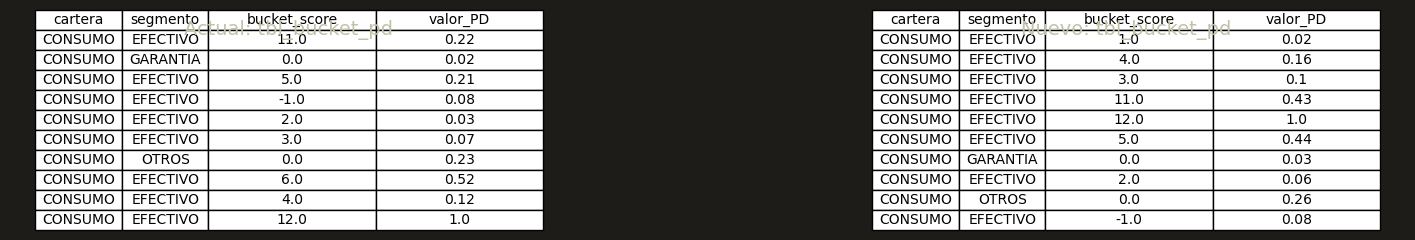

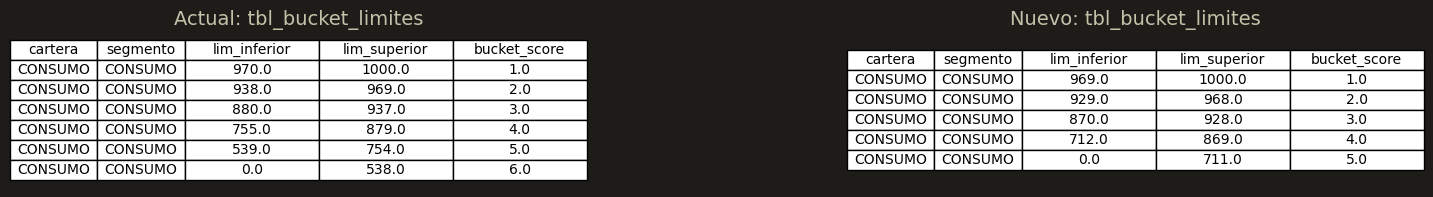

In [23]:
# mostrar nuevas tablas realizadas
for tbl_name in new_tables:

    if tbl_name in ["tbl_bucket_pd", "tbl_bucket_limites"]:
        original_name = f"Actual: {tbl_name}"
        new_name = f"Nuevo: {tbl_name}"
        if tbl_name == 'tbl_bucket_pd':
            display_dataframes_side_by_side(tablas_dict[tbl_name][tablas_dict[tbl_name]["cartera"]==cartera.upper()].head(10), 
                                            new_tables[tbl_name][new_tables[tbl_name]["cartera"]==cartera.upper()].head(10),
                                            original_name, 
                                            new_name)

        elif tbl_name == 'tbl_bucket_limites':
            display_dataframes_side_by_side(tablas_dict[tbl_name][tablas_dict[tbl_name]['cartera'].str.contains(cartera.upper(), na=False)].sort_values(by=['bucket_score']).head(10), 
                                            new_tables[tbl_name][new_tables[tbl_name]['cartera'].str.contains(cartera.upper(), na=False)].sort_values(by=['bucket_score']).head(10),
                                            original_name, 
                                            new_name)
    else:
        pass


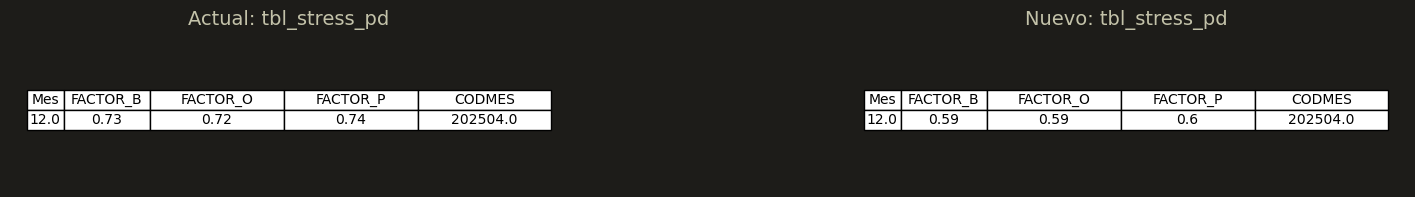

In [24]:
# mostrar nuevas tablas realizadas
for tbl_name in new_tables:

    if tbl_name in ["tbl_matriz_anual", "tbl_stress_pd"]:
        
        original_name = f"Actual: {tbl_name}"
        new_name = f"Nuevo: {tbl_name}"
        
        if tbl_name == 'tbl_matriz_anual':
            display_dataframes_side_by_side(tablas_dict[tbl_name][(tablas_dict[tbl_name]['N_bucket']==12.0)&(tablas_dict[tbl_name]['Periodo']=="Originacion")&(~tablas_dict[tbl_name]['N_estado_inicial'].isin([9.0, 10.0]))].sort_values(by=['N_estado_inicial']).head(10), 
                                            new_tables[tbl_name][(new_tables[tbl_name]['N_bucket']==12.0)&(new_tables[tbl_name]['Periodo']=="Originacion")&(~new_tables[tbl_name]['N_estado_inicial'].isin([9.0, 10.0]))].sort_values(by=['N_estado_inicial']).head(10),
                                            original_name, 
                                            new_name)
            
        elif tbl_name == 'tbl_stress_pd':
            display_dataframes_side_by_side(tablas_dict[tbl_name][(tablas_dict[tbl_name]['Mes']==12.0)].head(10), 
                                            new_tables[tbl_name][(new_tables[tbl_name]['Mes']==12.0)].head(10),
                                            original_name, 
                                            new_name)
    else:
        pass
        


In [25]:
modified_string = Change_thresholds(nb_params['cartera'], general_params_copy["t_stg_filtro_prelacion"], thresholds)\
                                    .update_thresholds()
new_params = {}
new_params = {"t_stg_filtro_prelacion": modified_string}

Umbrales modificados de CONSUMO


In [26]:
new_params['n_peso_b'] = n_peso_b
new_params['n_peso_o'] = n_peso_o
new_params['n_peso_p'] = n_peso_p

**Cambiando tablas actuales por nuevas**

In [27]:
for table_name in new_tables.keys():
    print(f"tablas_dict[{table_name}] <- new_tables[{table_name}]")
    tablas_dict_copy[table_name] = new_tables[table_name].copy()

tablas_dict[tbl_bucket_pd] <- new_tables[tbl_bucket_pd]
tablas_dict[tbl_bucket_limites] <- new_tables[tbl_bucket_limites]
tablas_dict[tbl_stress_pd] <- new_tables[tbl_stress_pd]


**Cambiando parametros**

In [28]:
for param_name in new_params.keys():
    print(f"general_params[{param_name}] <- new_params[{param_name}]")
    general_params_copy[param_name] = new_params[param_name]

general_params[t_stg_filtro_prelacion] <- new_params[t_stg_filtro_prelacion]
general_params[n_peso_b] <- new_params[n_peso_b]
general_params[n_peso_o] <- new_params[n_peso_o]
general_params[n_peso_p] <- new_params[n_peso_p]


In [29]:
new_tables_copy = tablas_dict_copy.copy()
new_general_params_copy = general_params_copy.copy()

tablas_params_manager = ParamsManager(tablas_dict_copy.copy())
general_params_manager = ParamsManager(general_params_copy.copy())

tablas = tablas_params_manager
variables = general_params_manager

T_cartera = variables.get_param("t_cartera")
T_cartera

'Consumo'

In [30]:
temp_tbl_rcd_prep_base, temp_tbl_rcd_marca_s2 = preparacion_bases(log_ejec_unico, n_paso_ejecucion, tablas, variables)
temp_tbl_asig_nivel_riesgo = asignacion_nivel_riesgo(log_ejec_unico, n_paso_ejecucion, tablas, variables, temp_tbl_rcd_prep_base)

No se actualizo la tabla AvanceEjecucion en Dynamo
-- Inicia la ejecucion del paso: Staging - Preparacion Bases
-- Culmina get parametros

--Tiempo de ejecucion del paso Staging - Preparacion Bases: 2.02
No se actualizo la tabla AvanceEjecucion en Dynamo
-- Inicia la ejecucion del paso: Staging - Asignacion Nivel Riesgo
--Tiempo de ejecucion del paso Staging - Asignacion Nivel Riesgo: 2.59


In [31]:
if T_cartera.upper() not in ['TARJETAS', 'RAPPI']:
    temp_tbl_asig_pd = asignacion_pd(log_ejec_unico, n_paso_ejecucion, tablas, variables, temp_tbl_asig_nivel_riesgo)
    
if T_cartera.upper() not in ['TARJETAS', 'RAPPI']:
    temp_tbl_vida_media = asignacion_vida_media(log_ejec_unico, n_paso_ejecucion, tablas, variables, temp_tbl_asig_pd)
    

if T_cartera.upper() not in ['TARJETAS', 'RAPPI']:
    if T_cartera.upper() in ['HIPOTECAS', 'CONVENIOS']:
        temp_tbl_pd_lifetime = asignacion_lifetime_HC(log_ejec_unico, n_paso_ejecucion, tablas, variables, temp_tbl_vida_media)
    else:
        temp_tbl_pd_lifetime = asignacion_lifetime(log_ejec_unico, n_paso_ejecucion, variables, temp_tbl_vida_media)
        
        
if T_cartera.upper() not in ['TARJETAS', 'RAPPI']:
    if T_cartera.upper() in ['HIPOTECAS', 'CONVENIOS']:
        temp_tbl_pd_lifetime = asignacion_lifetime_HC(log_ejec_unico, n_paso_ejecucion, tablas, variables, temp_tbl_vida_media)
    else:
        temp_tbl_pd_lifetime = asignacion_lifetime(log_ejec_unico, n_paso_ejecucion, variables, temp_tbl_vida_media)


No se actualizo la tabla AvanceEjecucion en Dynamo
-- Inicia la ejecucion del paso: Staging - Asignacion PD
--Tiempo de ejecucion del paso Staging - Asignacion PD: 1.31
No se actualizo la tabla AvanceEjecucion en Dynamo
-- Inicia la ejecucion del paso: Staging - Asignacion Vida Media
--Tiempo de ejecucion del paso Staging - Asignacion Vida Media: 1.07
No se actualizo la tabla AvanceEjecucion en Dynamo
-- Inicia la ejecucion del paso: Staging - Asignacion PD Lifetime
--Tiempo de ejecucion del paso Staging - Asignacion PD Lifetime: 0.15
No se actualizo la tabla AvanceEjecucion en Dynamo
-- Inicia la ejecucion del paso: Staging - Asignacion PD Lifetime
--Tiempo de ejecucion del paso Staging - Asignacion PD Lifetime: 0.13


In [32]:
%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [ ]:
start_time = current_time()

output_provisiones=[]
output_ead=[]
output_parametros=[]
output_tc_prodsubprod=[]
output_stats=[]

for k, escenario in enumerate(escenarios):
    print(escenario["t_nombre_escenario"])
    log_ejec = []

    if T_cartera.upper() not in ['TARJETAS', 'RAPPI']:
        temp_tbl_staging_stress, temp_tbl_stress_pd, N_stress_pd_fac_max, N_stress_pd_fac_Esc_actual_1 = stress_pd(log_ejec, n_paso_ejecucion, tablas, variables, escenario, temp_tbl_pd_lifetime)
    else:
        temp_tbl_pd_ref, temp_tbl_pd_ori, temp_tbl_pd_refinanciados, temp_tbl_pd_reprogramados, temp_tbl_pd_12_lt_missing, N_stress_pd_fac_Esc_actual_1 = MatricesPDStress(log_ejec, n_paso_ejecucion, tablas, variables, escenario)
        temp_tbl_staging_stress = StagingAsignacionPdTC(log_ejec, n_paso_ejecucion, tablas, variables, escenario, temp_tbl_asig_nivel_riesgo, temp_tbl_pd_ref, temp_tbl_pd_ori, temp_tbl_pd_refinanciados, temp_tbl_pd_reprogramados, temp_tbl_pd_12_lt_missing)
    temp_tbl_staging = asignacion_stage(log_ejec, n_paso_ejecucion, variables, temp_tbl_staging_stress)
    if T_cartera.upper() in ['TARJETAS', 'RAPPI']:
        temp_tbl_staging = AsignacionCcfEad(log_ejec, n_paso_ejecucion, tablas, variables, escenario, temp_tbl_staging)
        temp_ecl_stress_pd_marginal = None
        temp_tbl_ead_consolidada = None
    temp_tbl_staging_prov = asignacion_lgd_y_agregacion(log_ejec, n_paso_ejecucion, tablas, variables, escenario, temp_tbl_staging)
    if T_cartera.upper() not in ['TARJETAS', 'RAPPI']:
        if (k == 0) | (escenario['t_escenario'] == "N"):
            # EAD
            temp_tbl_cron_cartera_s1 = cron_cartera(log_ejec, n_paso_ejecucion, tablas, variables)
            temp_tbl_ead_saldo_base_ref = saldos_mes_referencia(log_ejec, n_paso_ejecucion, tablas, variables, temp_tbl_staging_prov, temp_tbl_cron_cartera_s1)
            temp_tbl_ead_cuotas_futuras = saldos_cuotas_futuras(log_ejec, n_paso_ejecucion, tablas, variables, temp_tbl_ead_saldo_base_ref, temp_tbl_cron_cartera_s1)
            temp_tbl_ead_consolidada = saldos_proyectados(log_ejec, n_paso_ejecucion, tablas, variables, temp_tbl_ead_saldo_base_ref, temp_tbl_ead_cuotas_futuras)
            # ECL
            temp_tbl_ecl_saldos_vp = saldo_anual_valorpresente(log_ejec, n_paso_ejecucion, variables, temp_tbl_ead_consolidada)
            temp_tbl_ecl_pd_lgd_ead = agregacion_pd_lgd_ead(log_ejec, n_paso_ejecucion, variables, temp_tbl_staging_prov, temp_tbl_ecl_saldos_vp)
            temp_tbl_pd_marg = asignacion_pd_marginal(log_ejec, n_paso_ejecucion, tablas, variables, temp_tbl_ecl_pd_lgd_ead)
        temp_ecl_stress_pd_marginal = stress_pd_marginal(log_ejec, n_paso_ejecucion, variables, N_stress_pd_fac_max, temp_tbl_stress_pd, temp_tbl_pd_marg)##
    temp_tbl_ecl_calculo_prov = calculo_provisiones(log_ejec, n_paso_ejecucion, tablas, variables, temp_ecl_stress_pd_marginal, temp_tbl_staging_prov)
    tabla_agregada_results = tabla_agregada(log_ejec, n_paso_ejecucion, tablas, variables, escenario, N_stress_pd_fac_Esc_actual_1, temp_tbl_ecl_calculo_prov, temp_tbl_rcd_prep_base, temp_tbl_staging_stress, temp_tbl_ead_consolidada, temp_tbl_rcd_marca_s2)
    
    output_provisiones.append(tabla_agregada_results["pe_total_escenario"])
    output_ead.append(tabla_agregada_results["ead_total_escenario"])
    output_parametros.append(tabla_agregada_results["pe_parametros_escenario"])
    output_tc_prodsubprod.append(tabla_agregada_results["prod_subprod_escenario"])
    output_stats.append(tabla_agregada_results["tabla_stats"])
    
end_time = current_time()


Base
No se actualizo la tabla AvanceEjecucion en Dynamo
-- Inicia la ejecucion del paso: Staging - Asignacion Stress PD
factor estres escenario:
11    0.59325
Name: N_FACTOR_ESC, dtype: float64
--Tiempo de ejecucion del paso Staging - Asignacion Stress PD: 0.68
No se actualizo la tabla AvanceEjecucion en Dynamo
-- Inicia la ejecucion del paso: Staging - Asignacion Stage
--Tiempo de ejecucion del paso Staging - Asignacion Stage: 0.63
No se actualizo la tabla AvanceEjecucion en Dynamo
-- Inicia la ejecucion del paso: Staging - Asignacion LGD
--Tiempo de ejecucion del paso Staging - Asignacion LGD: 109.04
No se actualizo la tabla AvanceEjecucion en Dynamo
-- Inicia la ejecucion del paso: EAD - Cronograma de pagos
--Tiempo de ejecucion del paso EAD - Cronograma de pagos: 3.98
No se actualizo la tabla AvanceEjecucion en Dynamo
-- Inicia la ejecucion del paso: EAD - Saldos mes referencia
--Tiempo de ejecucion del paso EAD - Saldos mes referencia: 19.14
No se actualizo la tabla AvanceEjecucio

In [ ]:
output_provisiones_full = pd.concat(output_provisiones, ignore_index = True)
output_ead_full = pd.concat(output_ead, ignore_index = True)
output_parametros_full = pd.concat(output_parametros, ignore_index = True)
output_tc_prodsubprod_full = pd.concat(output_tc_prodsubprod, ignore_index = True)
output_stats_full = pd.concat(output_stats, ignore_index = True)

## Exportar a S3

In [ ]:
bucket_name = "interbank-datalake-us-east-1-428938305480-discovery"
file_key = f"ifrs/discovery/discovery_riesgos_calibracion/Calibracion-{year}/Impactos/{nb_params['registro']}/resultados_he/{nb_params['periodo']}/carteras/{nb_params['cartera']}/output_v{nb_params['version']}"
print(file_key)

**tablas de salida**

In [ ]:
path_out = f"s3://{bucket_name}/{file_key}"

dict_exportacion = {"HOA_OUTPUTPROVISIONESCRED": output_provisiones_full,
                   "HOA_OUTPUTEADCONSOLIDADO": output_ead_full,
                   "HOA_OUTPUTMAESTROPARAMETROS": output_parametros_full,
                   "HOA_OUTPUTPRODSUBPRODTC": output_tc_prodsubprod_full,
                   "HOA_OUTPUTSTATS": output_stats_full}

for name, df in dict_exportacion.items():
    df.to_parquet(f"{path_out}/{name}.parquet")

**tablas de entrada**

In [ ]:
for name in tablas_dict:
    tablas.get_param(name).to_parquet(f"{path_out}/{name}.parquet")

**tablas intermedias**

In [ ]:
if T_cartera.upper() not in ['TARJETAS', 'RAPPI']:
    dict_exportacion_int = {"temp_tbl_rcd_prep_base": temp_tbl_rcd_prep_base,
                           "temp_tbl_rcd_marca_s2": temp_tbl_rcd_marca_s2,
                           "temp_tbl_asig_nivel_riesgo": temp_tbl_asig_nivel_riesgo,
                           "temp_tbl_vida_media": temp_tbl_vida_media,
                           "temp_tbl_pd_lifetime": temp_tbl_pd_lifetime}
else:
    dict_exportacion_int = {"temp_tbl_rcd_prep_base": temp_tbl_rcd_prep_base,
                           "temp_tbl_rcd_marca_s2": temp_tbl_rcd_marca_s2,
                           "temp_tbl_asig_nivel_riesgo": temp_tbl_asig_nivel_riesgo}

for name, df in dict_exportacion_int.items():
    df.to_parquet(f"{path_out}/{name}.parquet")

## VERSIONAMIETNO DE LOS PARAMETROS APLICADOS

In [ ]:
nb_params_version = {key: value for key, value in nb_params.items() if key in ['registro_ejec', 'cartera', 'periodo', 'version']}
nb_params_version['tablas actualizadas'] = ' - '.join(list(new_tables.keys()))
if nb_params['cartera'] not in ['corporativa', 'institucional', 'inmobiliarias']:
    if nb_params['cartera'] == 'hipotecas':
        string_mivienda = f"MiVivienda: {{{' - '.join(map(str,(thresholds[:2])))}}}"
        string_tradicional = f"Tradicional: {{{' - '.join(map(str,(thresholds[2:])))}}}"
        nb_params_version['umbrales actualizados'] = f"{string_mivienda}; {string_tradicional}"
    else:
        nb_params_version['umbrales actualizados'] = ' - '.join(map(str,(thresholds)))
else:
    nb_params_version['umbrales actualizados'] = 'cartera sin umbrales'

# output path
bucket_name = "interbank-datalake-us-east-1-428938305480-discovery/"
file_key_ouput = f"ifrs/discovery/discovery_riesgos_calibracion/Calibracion-{year}/Impactos/{nb_params['registro']}/resultados_he/{nb_params['periodo']}/carteras/{nb_params['cartera']}/output_v{nb_params['version']}"
ruta_output = "s3://" + bucket_name + file_key
nb_params_version['ruta_output'] = ruta_output

# Macroeconomic scenarios
parametros_fwl = {
                'base':new_params['n_peso_b'],
                'optimista':new_params['n_peso_o'],
                'pesimista':new_params['n_peso_p']
}

nb_params_version['pesos fwl'] = parametros_fwl

# Inputs tables names
tablas_inputs = {}
for key, value in total_tbl_names.items():
    tablas_inputs[key] = value
nb_params_version['Tablas inputs'] = tablas_inputs

# Inputs tables 1/0 version
inputs_tablas_dummy = dict(zip(list(total_tbl_names.keys()),vector_params)) 
nb_params_version['Actualizacion de tablas'] = inputs_tablas_dummy

# Json input
json_file
nb_params_version['JSON'] = json_file

# Time execution
spent_time = end_time - start_time
nb_params_version['Fecha, hora y tiempo de ejecucion'] = f"{format_time(start_time)} ::: [{execution_time_report(spent_time)}]"

nb_params_version = pd.DataFrame([nb_params_version])
nb_params_version = pd.DataFrame(nb_params_version.set_index(['cartera', 'periodo', 'version']).stack(), 
                                 columns = [''])
nb_params_version.index.names = ['cartera', 'periodo', 'version', 'parametro']
nb_params_version

## CALCULO DE PROVISIONES Y RESULTADOS

In [ ]:
pd.set_option('display.float_format', '{:.10f}'.format)
np.set_printoptions(suppress=True)
s3 = boto3.client('s3')

bucket_name = 'interbank-datalake-us-east-1-428938305480-discovery'
prefix = f'ifrs/discovery/discovery_riesgos_calibracion/Calibracion-{year}/Impactos/Notebooks/{periodo}/{cartera.upper()}/output_v{version}'
notebook = f'{prefix}/{notebook_name}'
json = f'{prefix}/{PARAMS_NAME}'

NOTEBOOK_PATH = 'Herramienta_estrategica.ipynb'
CSV_OUTPUT_PATH = f"{PARAMS_PATH.split('/params')[0]}/output_{cartera}_{periodo}_v{version}.csv"
nb_params_version.to_csv(CSV_OUTPUT_PATH)

## Provisiones

path_impactos = f"s3://{bucket_name}/{file_key}/HOA_OUTPUTPROVISIONESCRED.parquet"
impactos = pd.read_parquet(path_impactos)

ESC_BAS = n_peso_b
ESC_OPT = n_peso_o
ESC_PES = n_peso_p

path_with_name = f's3://{bucket_name}/{prefix}/impactos_he_{cartera}_{periodo}_v{version}.csv'

provisiones = calculo_provisiones_glue(impactos, cartera, ESC_BAS , ESC_OPT, ESC_PES, path_with_name)

provisiones_sm = f"{PARAMS_PATH.split('/params')[0]}/impactos_he_{cartera}_{periodo}_v{version}.csv"
provisiones.to_csv(provisiones_sm, index=False)

In [ ]:
provisiones

## SUBIDA DE RESULTADO

In [ ]:
# Sube el archivo al bucket
s3.upload_file(NOTEBOOK_PATH, bucket_name, notebook)
s3.upload_file(PARAMS_PATH, bucket_name, json)
s3.upload_file(CSV_OUTPUT_PATH, bucket_name,f'{prefix}/output_{cartera}_{periodo}_v{version}.csv')

In [ ]:
1

In [ ]:
1